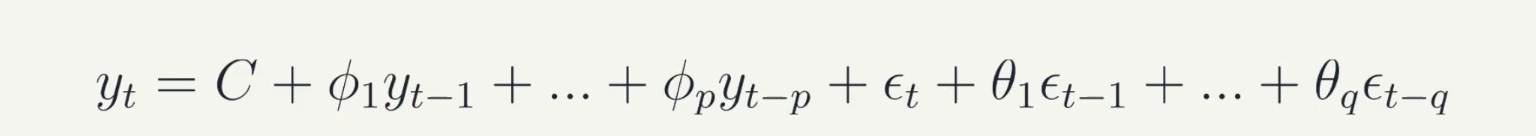

### ARMA Model is simply the combination of AR and MA Model.

### If both the ACF and PACF plot show a `sinusoidal or decaying pattern`, then we have an ARMA Process. ACF and PACF cannot be used to find the order of ARMA.


### `General Modelling Procedure:`

### 1. Starts by performing a stationary test and if its not, we apply transformation until it is.
### 2. List the possible combinations of P,q
### 3. Fit every ARMA(p,q) combination
### 4. `Select the model with lowest AIC`
### 5. Perform Residual Analysis - Q-Q Plot shows a strainght line?  and Residuals are uncorrelated? IF YES, THE MODEL IS READY FOR FORECAST

### `Akaike's Information Criteria(AIC)`: This is a measure of the quality of a model `in relation` to other models.

### AIC is a relative measure not an absolute measure.

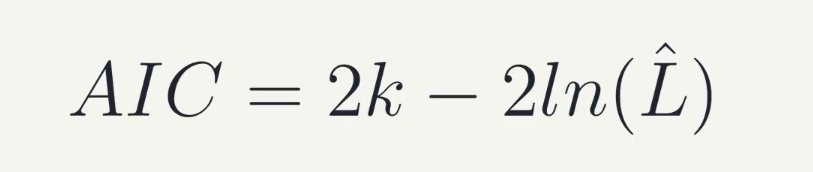

### AIC depends on the `number of parameters and likelihood function`

### If we have a lot of parameters, usually we get a `better fit` but it `penalises AIC`

### Likelihood function is the inverse of `Distribution function`

### In  Distribution function, given the parameters we calculate the probability of outcomes while in likelihood function, given the outcomes we estimate the parameters.

### `AIC strikes a balance between underfitting and overfitting`. Overfitting occurs when `AIC is large (when k and L are large)`. Underfitting occurs when `AIC is small(When k and L are small)`


### `Ljung box test`: It is used to determine if the data is autocorrelated or not. Null hypothesis: No Autocorrelation. if P > 0.05, then residuals are uncorrelated and independent.


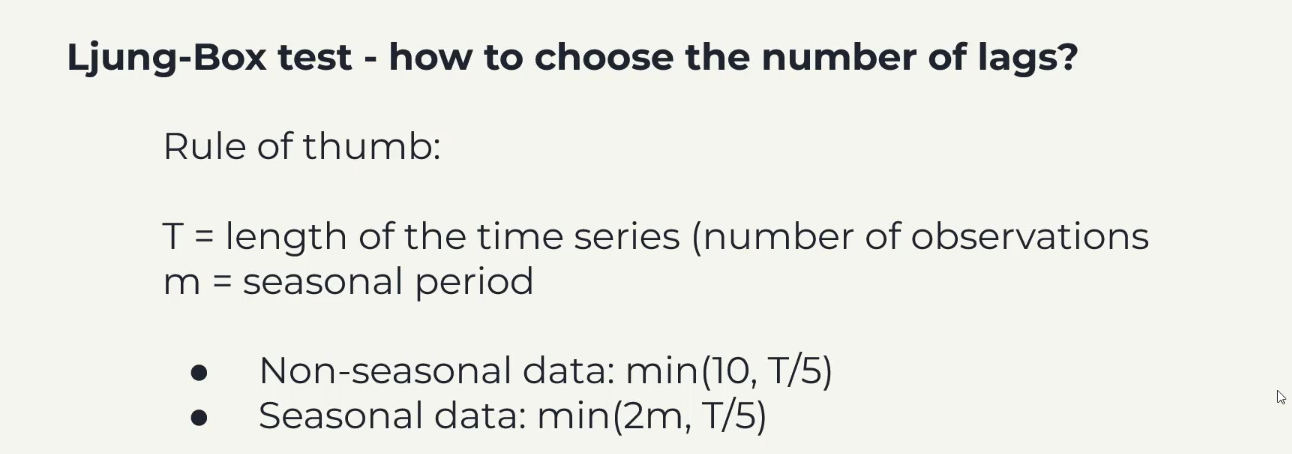

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [23]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [24]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042691
p-value: 1.7078466680096923e-08


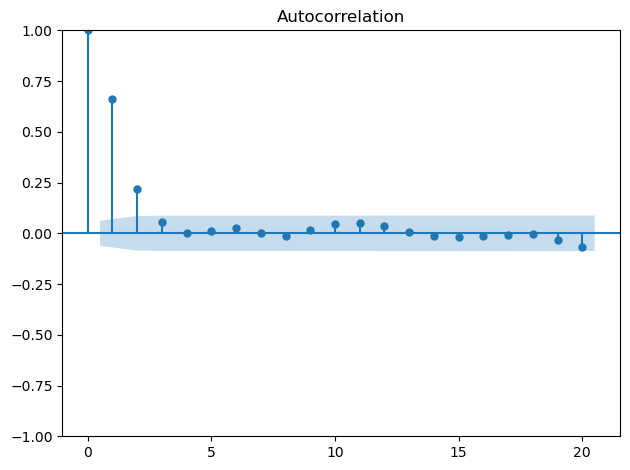

In [25]:
plot_acf(ARMA_1_1, lags=20);

plt.tight_layout()


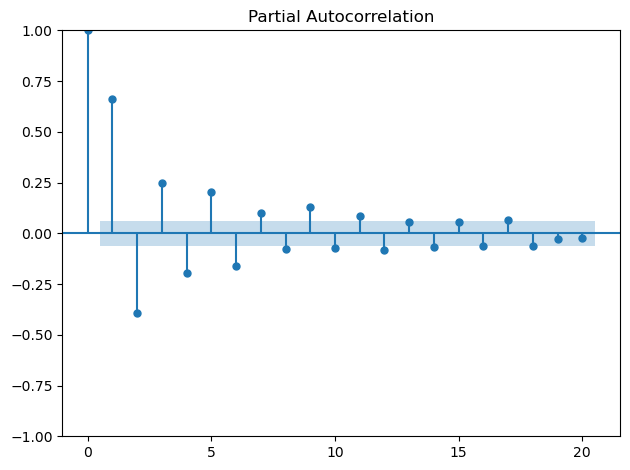

In [26]:
plot_pacf(ARMA_1_1, lags=20);

plt.tight_layout()


In [34]:
def ARMA_gridsearch(endog, min_p, max_p, min_q, max_q):
    
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_p_q = list(product(all_p, all_q))
    
    print(f'Trying {len(all_p_q)} unique models')
    
    results = []
    
    for each in tqdm_notebook(all_p_q):
        try:
            model = SARIMAX(endog, order=(each[0], 0, each[1])).fit()
        except:
            continnue
            
        results.append([each, model.aic])
        
    order_df = pd.DataFrame(results)
    order_df.columns = ['(p,q)', 'AIC']
    
    order_df = order_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return order_df

In [35]:
order_df = ARMA_gridsearch(ARMA_1_1, 0, 3, 0, 3)
order_df

Trying 16 unique models


  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.139215
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


In [36]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

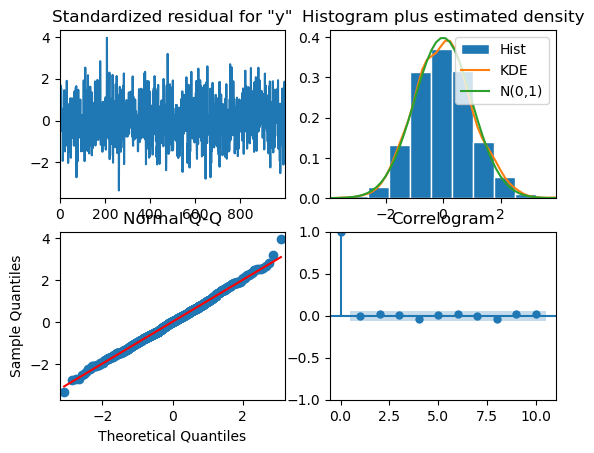

In [37]:
model_fit.plot_diagnostics();

In [38]:
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black')
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('One p-value is smaller than 0.05')

All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated


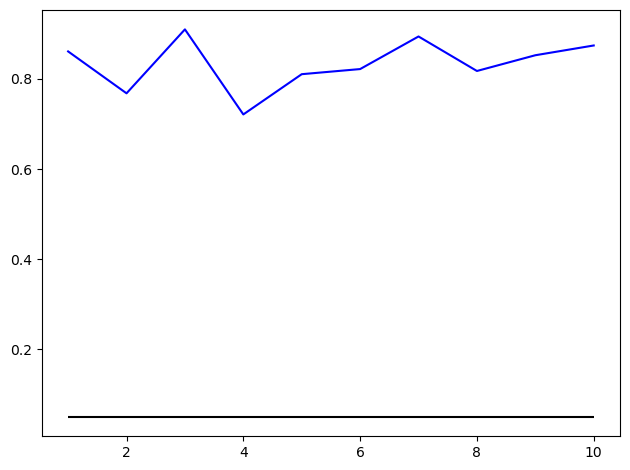

In [39]:
ljung_box_test(residuals, False, None)

In [40]:
def rolling_predictions(df_diff: pd.DataFrame, last_train_value: np.array, train_len: int, horizon: int, window: int, method: str) -> list:
    
    TOTAL_LEN = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df_diff[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        pred_mean = np.concatenate((last_train_value, pred_mean))
        pred_mean = pred_mean.cumsum()
        
        return pred_mean[:100]

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, TOTAL_LEN, window):
            last_value = df_diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        pred_last_value = np.concatenate((last_train_value, pred_last_value))
        pred_last_value = pred_last_value.cumsum()
        
        return pred_last_value[:100]
    
    if method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, TOTAL_LEN, window):
            model = SARIMAX(df_diff[:i], order=(1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        pred_ARMA = np.concatenate((last_train_value, pred_ARMA))
        pred_ARMA = pred_ARMA.cumsum()
            
        return pred_ARMA[:100]

In [41]:
# pred_df = df[-100:].copy()

# TRAIN_LEN = len(train)
# HORIZON = len(test)
# LAST_TRAIN_VALUE = df.iloc[899].values

# windows = [1, 2, 5, 10]

# for window in windows:
#     pred_mean = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'mean')
#     pred_last = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
#     pred_ARMA = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'ARMA')

#     pred_df[f'pred_mean_{window}'] = pred_mean
#     pred_df[f'pred_last_{window}'] = pred_last
#     pred_df[f'pred_ARMA_{window}'] = pred_ARMA

# pred_df.head()

In [42]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

# for i, ax in enumerate(axes.flatten()):
    
#     ax.plot(df['value'])
#     ax.plot(pred_df['value'], 'b-', label='actual')
#     ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
#     ax.plot(pred_df[f'pred_last_{windows[i]}'], 'r-.', label='last')
#     ax.plot(pred_df[f'pred_ARMA_{windows[i]}'], 'k--', label='ARMA(1,1)')
    
#     ax.legend(loc=2)
#     ax.set_xlabel('Time steps')
#     ax.set_ylabel('Value')
#     ax.axvspan(901, 1000, color='#808080', alpha=0.2)
#     ax.set_xlim(730, 1000)
#     ax.set_title(f'Horizon = {windows[i]}')
    
# plt.tight_layout()

In [43]:
# mae_mean_1 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_1'])
# mae_last_1 = mean_absolute_error(pred_df['value'], pred_df['pred_last_1'])
# mae_ARMA_1 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_1'])

# mae_mean_2 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_2'])
# mae_last_2 = mean_absolute_error(pred_df['value'], pred_df['pred_last_2'])
# mae_ARMA_2 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_2'])

# mae_mean_5 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_5'])
# mae_last_5 = mean_absolute_error(pred_df['value'], pred_df['pred_last_5'])
# mae_ARMA_5 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_5'])

# mae_mean_10 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_10'])
# mae_last_10 = mean_absolute_error(pred_df['value'], pred_df['pred_last_10'])
# mae_ARMA_10 = mean_absolute_error(pred_df['value'], pred_df['pred_ARMA_10'])

In [44]:
# maes_mean = [mae_mean_1, mae_mean_2, mae_mean_5, mae_mean_10]
# maes_last = [mae_last_1, mae_last_2, mae_last_5, mae_last_10]
# maes_ARMA = [mae_ARMA_1, mae_ARMA_2, mae_ARMA_5, mae_ARMA_10]

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

# x = ['mean', 'last', 'ARMA(1,1)']
# width = 0.3

# for i, ax in enumerate(axes.flatten()):
    
#     y = [maes_mean[i], maes_last[i], maes_ARMA[i]]
#     ax.bar(x, y, width)
#     ax.set_xlabel('Methods')
#     ax.set_ylabel('MAE')
#     ax.set_ylim(0, 20)
#     ax.set_title(f'Horizon = {windows[i]}')    
    
#     for index, value in enumerate(y):
#         ax.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

# plt.tight_layout()